In [ ]:
import joblib
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report


df = pd.read_csv(f"dataset.csv")

glcm_features = ["Contrast", "Dissimilarity", "Homogeneity", "Energy", "Correlation"]
resnet_features = [col for col in df.columns if col.startswith('deep_')]
feature_cols = glcm_features + resnet_features

X = df[feature_cols].values
y = df['label'].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, f'minmax_scaler.pkl')


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(517, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(128, 3)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        return self.output(x)

model = ANN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted_train = torch.max(outputs, 1)
    acc_train = (predicted_train == y_train_tensor).float().mean().item()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        _, predicted_test = torch.max(test_outputs, 1)
        acc_test = (predicted_test == y_test_tensor).float().mean().item()

    training_cost.append(loss.item())
    testing_cost.append(test_loss.item())
    training_accuracy.append(acc_train)
    testing_accuracy.append(acc_test)

torch.save(model.state_dict(), f'ann_model_state_dict.pth')
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred = torch.argmax(y_pred_logits, dim=1).numpy()

from torchsummary import summary
summary(model, (517,))


Training Epochs: 100%|██████████| 100/100 [00:02<00:00, 44.70it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         132,608
              ReLU-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 3]             387
Total params: 165,891
Trainable params: 165,891
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.63
Estimated Total Size (MB): 0.64
----------------------------------------------------------------


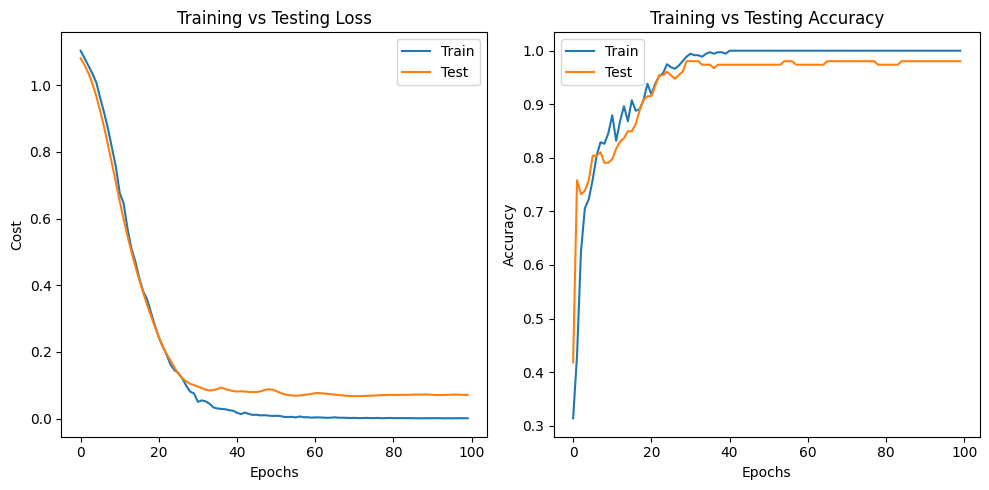

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Cost Plot
plt.subplot(1, 2, 1)
plt.plot(training_cost, label='Train')
plt.plot(testing_cost, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Training vs Testing Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Train')
plt.plot(testing_accuracy, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       1.00      0.98      0.99        51
           2       0.96      0.98      0.97        51

    accuracy                           0.98       153
   macro avg       0.98      0.98      0.98       153
weighted avg       0.98      0.98      0.98       153



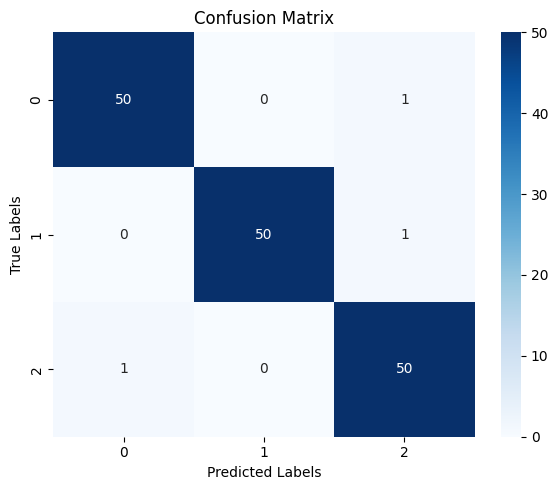

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
class_names = np.unique(y_test)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()